In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
#the data set
df = pd.read_csv('./accepted_2007_to_2018Q4.csv')

/tmp/ipykernel_7870/1581045252.py:2: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./accepted_2007_to_2018Q4.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [4]:
#limit the number of observations to 20 000
df = df.sample(n=20000, random_state=42)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 392949 to 130805
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 23.2+ MB


In [6]:
#check sum of missing values
missing_values = df.isnull().sum()

In [7]:
missing_values

id                           0
member_id                20000
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
                         ...  
settlement_status        19643
settlement_date          19643
settlement_amount        19643
settlement_percentage    19643
settlement_term          19643
Length: 151, dtype: int64

In [8]:
#calculate percentage of the missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100

In [9]:
#create a list of columns where more than 50% of observations are missing
columns_to_drop = missing_percentage[missing_percentage > 50].index

In [10]:
#drop columns where more than 50% of observations are missing
df = df.drop(columns=columns_to_drop)

In [11]:
#check how many columns left
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 392949 to 130805
Columns: 107 entries, id to debt_settlement_flag
dtypes: float64(83), object(24)
memory usage: 16.5+ MB


In [12]:
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title',
       ...
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object', length=107)

In [13]:
#drop "id" column since it is noninformative
df = df.drop("id", axis=1)

In [14]:
#checking the missing values in other columns
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values != 0]

In [15]:
#print columns with the missing values
print(columns_with_missing_values)

emp_title                     1417
emp_length                    1228
title                          192
dti                             15
revol_util                      12
last_pymnt_d                    28
collections_12_mths_ex_med       1
tot_coll_amt                   626
tot_cur_bal                    626
open_acc_6m                   7634
open_act_il                   7634
open_il_12m                   7634
open_il_24m                   7634
mths_since_rcnt_il            7985
total_bal_il                  7634
il_util                       9390
open_rv_12m                   7634
open_rv_24m                   7634
max_bal_bc                    7634
all_util                      7634
total_rev_hi_lim               626
inq_fi                        7634
total_cu_tl                   7634
inq_last_12m                  7634
acc_open_past_24mths           423
avg_cur_bal                    626
bc_open_to_buy                 664
bc_util                        673
chargeoff_within_12_

In [16]:
#fill missing values with fillna forward method 
df = df.fillna(method='ffill')

In [17]:
#checking the missing values again
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values != 0]

In [18]:
#print columns with the missing values again
print(columns_with_missing_values)

open_acc_6m           3
open_act_il           3
open_il_12m           3
open_il_24m           3
mths_since_rcnt_il    3
total_bal_il          3
il_util               3
open_rv_12m           3
open_rv_24m           3
max_bal_bc            3
all_util              3
inq_fi                3
total_cu_tl           3
inq_last_12m          3
dtype: int64


In [19]:
#drop the rest of the rows with missing values 
df = df.dropna()

In [20]:
#checking the missing values
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values != 0]

In [21]:
#print columns to check the missing values again
print(columns_with_missing_values)

Series([], dtype: int64)


In [22]:
#create a new dataset to store the encoded values
df_encoded = df.copy()

In [23]:
#create a list of columns with dtype object
object_columns = df_encoded.select_dtypes(include=['object']).columns.tolist()

In [24]:
#apply LabelEncoder to the object columns
label_encoder = LabelEncoder()
df_encoded[object_columns] = df_encoded[object_columns].apply(lambda x: label_encoder.fit_transform(x.astype(str)))

In [25]:
#check the column "term" which will be my target
df_encoded['term']

2066630    0
477199     1
1975547    0
302723     0
1972188    1
          ..
1952068    0
1504899    0
597582     0
1981329    1
130805     0
Name: term, Length: 19997, dtype: int64

In [26]:
#check unique values in the target "term" column
df_encoded['term'].unique()

array([0, 1])

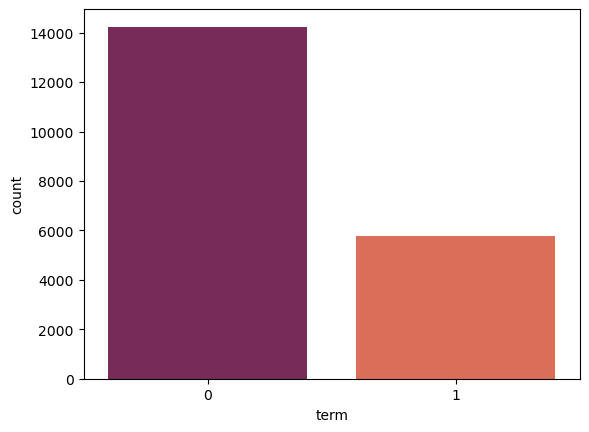

In [27]:
#plot a barplot for the column to check if the classes have equal sizes
ax = sns.countplot(x='term', data=df_encoded, palette="rocket")
plt.show()

In [28]:
#define the target and the features
target = 'term'
X = df_encoded.drop([target],axis=1).copy()#features
y = df_encoded[target].copy() #target

In [29]:
#split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
#create Random Forest model for classification
rfc=RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5, class_weight='balanced')

In [31]:
rfc.fit(X_train, y_train)#fit

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [32]:
y_pred = rfc.predict(X_test)#predict

In [33]:
# print the classification report for the Random Forest Classifier model for all the data in df
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      4741
           1       0.61      0.94      0.74      1859

    accuracy                           0.82      6600
   macro avg       0.79      0.86      0.80      6600
weighted avg       0.87      0.82      0.83      6600



In [34]:
# Select 50% of the columns randomly
df_random_columns_50_pct  = df_encoded.drop(target, axis=1).sample(frac=0.5, axis=1).copy()

In [35]:
df_random_columns_50_pct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19997 entries, 2066630 to 130805
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   inq_fi                      19997 non-null  float64
 1   earliest_cr_line            19997 non-null  int64  
 2   mths_since_recent_bc        19997 non-null  float64
 3   last_pymnt_amnt             19997 non-null  float64
 4   open_il_24m                 19997 non-null  float64
 5   addr_state                  19997 non-null  int64  
 6   inq_last_12m                19997 non-null  float64
 7   loan_amnt                   19997 non-null  float64
 8   total_bc_limit              19997 non-null  float64
 9   delinq_2yrs                 19997 non-null  float64
 10  mort_acc                    19997 non-null  float64
 11  open_rv_24m                 19997 non-null  float64
 12  fico_range_high             19997 non-null  float64
 13  recoveries              

In [36]:
#define the target and the features for the randomly selected 50% columns
if target in df_random_columns_50_pct.columns:
    X_50 = df_random_columns_50_pct.drop([target],axis=1).copy()#features
else:
    X_50 = df_random_columns_50_pct.copy()
y_50 = df_encoded[target].copy() #target

In [37]:
#split data into train and test data for the randomly selected 50% columns
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_50, y_50, test_size=0.33, random_state=42)

In [38]:
#create model
rfc_50=RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5, class_weight='balanced')

In [39]:
rfc_50.fit(X_train_50, y_train_50)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [40]:
y_pred_50 = rfc_50.predict(X_test_50)

In [41]:
# print the classification report for the Random Forest Classifier model for the randomly selected 50% columns
print(classification_report(y_test_50, y_pred_50))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81      4741
           1       0.55      0.94      0.69      1859

    accuracy                           0.77      6600
   macro avg       0.76      0.82      0.75      6600
weighted avg       0.85      0.77      0.78      6600



In [42]:
#create a new dataset for PCA algorythm
df_pca = df_encoded.drop(target, axis=1)

In [43]:
#scale the PCA dataset
scaler = StandardScaler()
scaled_data_pca = scaler.fit_transform(df_pca)

In [44]:
X_PCA = scaled_data_pca.copy()#features
y_PCA = df_encoded[target].copy() #target

In [45]:
#split data into train and test data
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y_PCA, test_size=0.33, random_state=42)

In [46]:
#apply PCA
pca = PCA(n_components=None)
pca.fit(X_train_PCA)

PCA()

In [47]:
#calculate explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

In [48]:
np.cumsum(explained_variance_ratios)>0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [49]:
cumsum_explained_v_ratio = np.cumsum(explained_variance_ratios)

In [50]:
#check how many columns have the explained variance under 50%
(cumsum_explained_v_ratio<0.5).sum()

12

In [51]:
#apply PCA with number of compononets 13 (12 +1)
pca = PCA(n_components=13)
pca_features = pca.fit_transform(X_test_PCA)

In [52]:
#create model
rfc_PCA=RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5, class_weight='balanced')

In [53]:
rfc_PCA.fit(X_train_PCA, y_train_PCA)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [54]:
y_pred_PCA = rfc_PCA.predict(X_test_PCA)

In [55]:
# print the classification report for the Random Forest Classifier model for PCA dataset
print(classification_report(y_test_PCA, y_pred_PCA))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      4741
           1       0.61      0.94      0.74      1859

    accuracy                           0.82      6600
   macro avg       0.79      0.86      0.80      6600
weighted avg       0.87      0.82      0.83      6600



In [56]:
#define a new dataset for LDA algorythm
df_lda = df_encoded.drop(target, axis=1)

In [57]:
#scale the LDA dataset
scaled_data_lda = scaler.fit_transform(df_lda)

In [58]:
X_LDA = scaled_data_lda
y_LDA = df_encoded[target]

In [60]:
# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=None)
lda.fit(X_train_LDA, y_train_LDA)

LinearDiscriminantAnalysis()

In [61]:
explained_variance_ratios_lda = lda.explained_variance_ratio_

In [62]:
explained_variance_ratios_lda

array([1.])

In [63]:
np.cumsum(explained_variance_ratios_lda)>0.5

array([ True])

In [64]:
lda = LinearDiscriminantAnalysis(n_components=1)

In [65]:
lda_features = lda.fit_transform(df_lda, y)

In [66]:
#split data into train and test data for LDA
X_train_LDA, X_test_LDA, y_train_LDA, y_test_LDA = train_test_split(X_LDA, y_LDA, test_size=0.33, random_state=42)

In [67]:
#create model for LDA dataset
rfc_LDA=RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5, class_weight='balanced')

In [68]:
rfc_LDA.fit(X_train_LDA, y_train_LDA)#fit

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [69]:
y_pred_LDA = rfc_LDA.predict(X_test_LDA)#predict

In [70]:
# print the classification report for the Random Forest Classifier model for LDA dataset
print(classification_report(y_test_LDA, y_pred_LDA))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      4741
           1       0.61      0.94      0.74      1859

    accuracy                           0.82      6600
   macro avg       0.79      0.86      0.80      6600
weighted avg       0.87      0.82      0.83      6600



In [71]:
# Retrieve feature importances
importances = rfc.feature_importances_

# Associate feature importances with feature names
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print(sorted_importances.head(6))


            Feature  Importance
0         loan_amnt    0.154992
2   funded_amnt_inv    0.135867
1       funded_amnt    0.130598
37    total_rec_int    0.091914
6         sub_grade    0.089155
4       installment    0.072127


In [72]:
sorted_importances["Feature"].head(6)

0           loan_amnt
2     funded_amnt_inv
1         funded_amnt
37      total_rec_int
6           sub_grade
4         installment
Name: Feature, dtype: object

In [73]:
features = sorted_importances.iloc[:6]['Feature'].tolist()

In [74]:
#define the target and the features for the selected columns based on feture importance
X_feature_importance = df_encoded[features].copy()#features
y_feature_importance = df_encoded[target].copy() #target

In [75]:
#split data into train and test data
X_train_feature_importance, X_test_feature_importance, y_train_feature_importance, y_test_feature_importance = train_test_split(X_feature_importance, y_feature_importance, test_size=0.33, random_state=42)

In [76]:
#create model
rfc_feature_importance=RandomForestClassifier(random_state=42, n_estimators=200, max_depth=5, class_weight='balanced')

In [77]:
rfc_feature_importance.fit(X_train_feature_importance, y_train_feature_importance)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200,
                       random_state=42)

In [78]:
y_pred_feature_importance = rfc_feature_importance.predict(X_test_feature_importance)

In [79]:
# print the classification report for the Random Forest Classifier model
print(classification_report(y_test_feature_importance, y_pred_feature_importance))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      4741
           1       0.73      0.97      0.84      1859

    accuracy                           0.89      6600
   macro avg       0.86      0.92      0.88      6600
weighted avg       0.92      0.89      0.90      6600



In [80]:
#tests with different PCA hyperparameters values
pca_test = PCA(n_components=30)
pca_test.fit(scaled_data_pca)

PCA(n_components=30)

In [81]:
selected_columns_pca_test = pd.DataFrame(scaled_data_pca)

In [82]:
pca_test.explained_variance_ratio_.sum()

0.7139382119764133

In [83]:
#define the target and the features for the PCA 
X_PCA_test = selected_columns_pca_test.copy()#features
y_PCA_test = df_encoded[target].copy() #target

In [84]:
#split data into train and test data
X_train_PCA_test, X_test_PCA_test, y_train_PCA_test, y_test_PCA_test = train_test_split(X_PCA_test, y_PCA_test, test_size=0.33, random_state=42)

In [85]:
#create model
rfc_PCA_test=RandomForestClassifier(random_state=42, n_estimators=200, max_depth=5, class_weight='balanced')

In [86]:
rfc_PCA_test.fit(X_train_PCA_test, y_train_PCA_test)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200,
                       random_state=42)

In [87]:
y_pred_PCA_test = rfc_PCA_test.predict(X_test_PCA_test)

In [88]:
# print the classification report for the Random Forest Classifier mode
print(classification_report(y_test_PCA_test, y_pred_PCA_test))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      4741
           1       0.62      0.94      0.74      1859

    accuracy                           0.82      6600
   macro avg       0.79      0.86      0.80      6600
weighted avg       0.87      0.82      0.83      6600

